# **Refinement**

**Project Milestone 4**

**Team:** B1 Team 13

**Team Member:** Mohamad Gong

# Introduction

Milestone 4 constitutes a serious analytical checkpoint in this project. This submission is intended to demonstrate a mature understanding of the dataset and the fair use domain, along with significant progress toward well-supported high-level findings and insightful interpretation.

In earlier milestones, I established the core framing for Q2: venue-level differences can be misleading if courts and circuits see different mixes of dispute types. This notebook focuses on making those comparisons more credible by grouping cases into comparable case types and then evaluating whether venue effects persist after controlling for that case mix.

The main methodological shift in M4 is how case types are constructed. Prior work relied on TF-IDF and NMF, which represent documents through word and phrase frequency patterns and then summarize them into topic mixtures. That approach is interpretable and effective for identifying recurring terms, but it is still largely driven by lexical overlap. In this notebook, I move to text embeddings and similarity-based clustering, which represent each case as a dense semantic vector and group cases by semantic similarity rather than only shared vocabulary.

The benefit of this upgrade is that it better handles paraphrasing, synonyms, and stylistic differences across court descriptions, which are common in legal summaries. It also reduces the risk that boilerplate language dominates the grouping, and it supports more coherent and stable case types for downstream analysis. As a result, the venue comparisons are more aligned with the goal of assessing differences that remain after accounting for dispute type.

The notebook is organized to remain rigorous and interpretable. It includes clear preprocessing choices, transparent cluster interpretation through keywords and representative examples, and robustness checks such as parameter sensitivity and stability across runs. The main outputs are a case type dictionary and a venue comparison table reporting adjusted outcomes, supported by focused visualizations that make the results easy to evaluate.

# Setting Up Environment

In [59]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Data Importing, Inspection and Preparation

## Data Importing

Because merging `fair_use_cases` and `fair_use_findings` is unreliable and can introduce case loss or mismatches, this notebook uses `fair_use_findings` as the sole analysis table. This keeps the pipeline reproducible and preserves maximum coverage for the text-based modeling steps.

In [60]:
fair_use_findings = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-29/fair_use_findings.csv')

## Data Inspection

The `fair_use_findings` table contains complementary case-level text, including summaries of key facts, legal issues, holdings, and descriptive tags. Inspection centers on text completeness and variability, as these fields support later analysis of language patterns, similarity, and thematic structure across cases.

| variable    | class     | description                                                                            |
| ----------- | --------- | -------------------------------------------------------------------------------------- |
| title       | character | The title of the case.                                                                 |
| case_number | character | The case number or numbers of the case.                                                |
| year        | character | The year in which the finding was made (or findings were made).                        |
| court       | character | The court or courts involved.                                                          |
| key_facts   | character | The key facts of the case.                                                             |
| issue       | character | A brief description of the fair use issue.                                             |
| holding     | character | The decision of the court in paragraph form.                                           |
| tags        | character | Comma- or semicolon-separated tags for this case.                                      |
| outcome     | character | A brief description of the outcome of the case. These fields have not been normalized. |

In [61]:
print("Dataset Info:")
print(fair_use_findings.info())

print("\nFirst 5 rows:")
print(fair_use_findings.head())

print("\nMissing Values:")
print(fair_use_findings.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        251 non-null    object
 1   case_number  251 non-null    object
 2   year         251 non-null    object
 3   court        251 non-null    object
 4   key_facts    251 non-null    object
 5   issue        251 non-null    object
 6   holding      251 non-null    object
 7   tags         251 non-null    object
 8   outcome      251 non-null    object
dtypes: object(9)
memory usage: 17.8+ KB
None

First 5 rows:
                                               title  \
0                              De Fontbrune v. Wofsy   
1                          Sedlik v. Von Drachenberg   
2  Sketchworks Indus. Strength Comedy, Inc. v. Ja...   
3  Am. Soc'y for Testing & Materials v. Public.Re...   
4                           Yang v. Mic Network Inc.   

                                 

## Preparing Data

### Outcome Flag Construction

The outcome column is converted into a simple label for analysis. The text is cleaned and then grouped into three outcomes: fair use found, fair use not found, and indeterminate (preliminary, mixed, remand, or unclear). A binary fair_use_found flag is created only for the final outcomes, and indeterminate cases are left out of binary rate calculations.

In [62]:
# Count outcome column from fair_use_findings and reset index
outcome_counts = fair_use_findings["outcome"].astype(str).str.lower().str.strip().value_counts().reset_index()
fair_use_findings["outcome"] = fair_use_findings["outcome"].astype(str).str.lower().str.strip()
outcome_counts.columns = ["outcome", "count"]

# Display the counts
print(outcome_counts)

                                              outcome  count
0                                  fair use not found    100
1                                      fair use found     98
2         preliminary ruling, mixed result, or remand     28
3             preliminary finding; fair use not found      4
4                                        mixed result      3
5              preliminary ruling, fair use not found      3
6              fair use not found, preliminary ruling      3
7              preliminary ruling; fair use not found      2
8              fair use not found; preliminary ruling      2
9                          preliminary ruling, remand      1
10                                fair use not found.      1
11                                    fair use found.      1
12  preliminary ruling, fair use not found, mixed ...      1
13                 preliminary ruling, fair use found      1
14  fair use found; second circuit affirmed on app...      1
15                      

Based on the grouped outcome counts, outcomes fall into three clear categories. Entries labeled “Fair use found” (including minor punctuation or appeal notes) are treated as fair use found, and entries labeled “Fair use not found” (including punctuation variants) are treated as fair use not found. All remaining outcomes, such as preliminary rulings, mixed results, remands, and irregular text entries, are treated as indeterminate. A binary fair_use_found flag is then defined only for the final outcomes, while indeterminate cases are excluded from binary rate calculations.

In [63]:
outcome_map = {
    # FINAL: fair use found
    "fair use found": "FAIR_USE_FOUND",
    "fair use found.": "FAIR_USE_FOUND",
    "fair use found; second circuit affirmed on appeal.": "FAIR_USE_FOUND",

    # FINAL: fair use not found
    "fair use not found": "FAIR_USE_NOT_FOUND",
    "fair use not found.": "FAIR_USE_NOT_FOUND",

    # INDETERMINATE
    "preliminary ruling, mixed result, or remand": "INDETERMINATE",
    "preliminary finding; fair use not found": "INDETERMINATE",
    "mixed result": "INDETERMINATE",
    "preliminary ruling, fair use not found": "INDETERMINATE",
    "fair use not found, preliminary ruling": "INDETERMINATE",
    "preliminary ruling; fair use not found": "INDETERMINATE",
    "fair use not found; preliminary ruling": "INDETERMINATE",
    "preliminary ruling, remand": "INDETERMINATE",
    "preliminary ruling, fair use not found, mixed result": "INDETERMINATE",
    "preliminary ruling, fair use found": "INDETERMINATE",
    "fair use found; mixed result": "INDETERMINATE",
    "plaintiff patrick cariou published yes rasta, a book of portraits and landscape photographs taken in jamaica. defendant richard prince was an appropriation artist who altered and incorporated several of plaintiff’s photographs into a series of paintings and collages called canal zone that was exhibited at a gallery and in the gallery’s exhibition catalog. plaintiff filed an infringement claim, and the district court ruled in his favor, stating that to qualify as fair use, a secondary work must “comment on, relate to the historical context of, or critically refer back to the original works.” defendant appealed.": "INDETERMINATE",
}

In [64]:
# Create outcome_std using the mapping from outcome_map
fair_use_findings["outcome_std"] = fair_use_findings["outcome"].replace(outcome_map)

# Create a boolean flag for determinate cases (True if Fair Use Found or Not Found)
fair_use_findings["is_determinate"] = fair_use_findings["outcome_std"].isin(["FAIR_USE_FOUND", "FAIR_USE_NOT_FOUND"])

# Display counts for verification
print("Outcome Standardized Counts:")
print(fair_use_findings["outcome_std"].value_counts())
print("\nIs Determinate Counts:")
print(fair_use_findings["is_determinate"].value_counts())

Outcome Standardized Counts:
outcome_std
FAIR_USE_NOT_FOUND    101
FAIR_USE_FOUND        100
INDETERMINATE          50
Name: count, dtype: int64

Is Determinate Counts:
is_determinate
True     201
False     50
Name: count, dtype: int64


### Year Type Conversion

The `year` column is converted to a numeric integer format to ensure it can be used reliably in grouping, filtering, and any downstream modeling steps. Any non-numeric or missing values are handled safely during conversion.

In [65]:
# Turn the year column to integer
fair_use_findings["year"] = pd.to_numeric(fair_use_findings["year"], errors="coerce").astype("Int64")

In [66]:
fair_use_findings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           251 non-null    object
 1   case_number     251 non-null    object
 2   year            250 non-null    Int64 
 3   court           251 non-null    object
 4   key_facts       251 non-null    object
 5   issue           251 non-null    object
 6   holding         251 non-null    object
 7   tags            251 non-null    object
 8   outcome         251 non-null    object
 9   outcome_std     251 non-null    object
 10  is_determinate  251 non-null    bool  
dtypes: Int64(1), bool(1), object(9)
memory usage: 20.2+ KB


### Venue Label Construction

Court strings appear in many formats (district courts, courts of appeals, Supreme Court, and occasional formatting variants). This step standardizes the court text and assigns each row to a circuit-level venue label when possible, so venue comparisons are not fragmented across many nearly-unique court strings.

In [75]:
fair_use_findings["court"] = fair_use_findings["court"].astype(str).str.strip()
court_norm = fair_use_findings["court"].str.replace(r"\s+", " ", regex=True)
court_norm = court_norm.str.replace("U.S.", "United States", regex=False)
court_norm = court_norm.str.replace("United Stated", "United States", regex=False)
court_norm = court_norm.str.replace("Court of Appeal", "Court of Appeals", regex=False)
fair_use_findings["court_norm"] = court_norm

lower = fair_use_findings["court_norm"].str.lower()

# Extract explicitly named circuits (e.g., "Ninth Circuit")
circuit_token = lower.str.extract(
    r"\b(first|second|third|fourth|fifth|sixth|seventh|eighth|ninth|tenth|eleventh|d\.c\.|federal)\s+circuit\b",
    expand=False
)

def format_circuit(x):
    if pd.isna(x):
        return pd.NA
    if x == "d.c.":
        return "D.C. Circuit"
    if x == "federal":
        return "Federal Circuit"
    return x.title() + " Circuit"

circuit_from_text = circuit_token.map(format_circuit)

# extract state names to map district courts to their circuits
state = lower.str.extract(r"district of ([a-z .]+)", expand=False)
state = state.str.replace(r"\s+", " ", regex=True).str.strip()
state = state.str.title()

state_to_circuit = {
    "Maine": "First Circuit", "Massachusetts": "First Circuit", "New Hampshire": "First Circuit",
    "Rhode Island": "First Circuit", "Puerto Rico": "First Circuit",
    "Connecticut": "Second Circuit", "New York": "Second Circuit", "Vermont": "Second Circuit",
    "Delaware": "Third Circuit", "New Jersey": "Third Circuit", "Pennsylvania": "Third Circuit", "Virgin Islands": "Third Circuit",
    "Maryland": "Fourth Circuit", "North Carolina": "Fourth Circuit", "South Carolina": "Fourth Circuit",
    "Virginia": "Fourth Circuit", "West Virginia": "Fourth Circuit",
    "Louisiana": "Fifth Circuit", "Mississippi": "Fifth Circuit", "Texas": "Fifth Circuit",
    "Kentucky": "Sixth Circuit", "Michigan": "Sixth Circuit", "Ohio": "Sixth Circuit", "Tennessee": "Sixth Circuit",
    "Illinois": "Seventh Circuit", "Indiana": "Seventh Circuit", "Wisconsin": "Seventh Circuit",
    "Arkansas": "Eighth Circuit", "Iowa": "Eighth Circuit", "Minnesota": "Eighth Circuit", "Missouri": "Eighth Circuit",
    "Nebraska": "Eighth Circuit", "North Dakota": "Eighth Circuit", "South Dakota": "Eighth Circuit",
    "Alaska": "Ninth Circuit", "Arizona": "Ninth Circuit", "California": "Ninth Circuit", "Hawaii": "Ninth Circuit",
    "Idaho": "Ninth Circuit", "Montana": "Ninth Circuit", "Nevada": "Ninth Circuit", "Oregon": "Ninth Circuit",
    "Washington": "Ninth Circuit", "Guam": "Ninth Circuit", "Northern Mariana Islands": "Ninth Circuit",
    "Colorado": "Tenth Circuit", "Kansas": "Tenth Circuit", "New Mexico": "Tenth Circuit", "Oklahoma": "Tenth Circuit",
    "Utah": "Tenth Circuit", "Wyoming": "Tenth Circuit",
    "Alabama": "Eleventh Circuit", "Florida": "Eleventh Circuit", "Georgia": "Eleventh Circuit",
    "Columbia": "D.C. Circuit"
}

circuit_from_state = state.map(state_to_circuit)

# Handle special courts like Supreme Court and Federal Claims
circuit_special = pd.Series(pd.NA, index=fair_use_findings.index, dtype="object")
circuit_special = circuit_special.mask(lower.str.contains("supreme court"), "Supreme Court")
circuit_special = circuit_special.mask(
    lower.str.contains("court of federal claims") | lower.str.contains("court of claims"),
    "Federal Circuit"
)

# Combine mappings: prefer explicit text, then state mapping, then special cases
fair_use_findings["venue_label"] = circuit_from_text.fillna(circuit_from_state).fillna(circuit_special)

venue_counts = fair_use_findings["venue_label"].value_counts(dropna=False).reset_index()
venue_counts.columns = ["venue_label", "count"]
print(venue_counts)

         venue_label  count
0     Second Circuit     98
1      Ninth Circuit     63
2   Eleventh Circuit     13
3    Seventh Circuit     12
4     Fourth Circuit     11
5      Fifth Circuit     10
6      First Circuit     10
7      Sixth Circuit      9
8      Third Circuit      8
9      Supreme Court      5
10   Federal Circuit      4
11      D.C. Circuit      3
12    Eighth Circuit      3
13     Tenth Circuit      2


Venue labels are now fully standardized, with **0 missing assignments**. The resulting distribution shows that most cases fall within the Second and Ninth Circuits, with additional coverage across the remaining regional circuits, plus small counts for the Supreme Court, D.C. Circuit, and Federal Circuit. This circuit-level `venue_label` will be used for Q2 to avoid fragmentation from many court-name variants and to ensure venue comparisons are made at a consistent level in the federal judicial structure.

# Preprocessing

## Embedding-Ready Text Construction

This step prepares the narrative text fields for embedding by applying light, consistent cleaning. The `issue`, `key_facts`, and `court` columns are standardized by removing nulls and normalizing whitespace so the embedding model receives clean, uniform input text. A single modeling text field is then constructed by concatenating `issue_clean` and `facts_clean`, which captures the dispute substance that will be used to define case similarity.

In [68]:
# Create a working copy of the dataset
df = fair_use_findings.copy()

# Define a function to clean text by handling nulls and standardizing whitespace
def clean_text(s):
    s = "" if pd.isna(s) else str(s)
    s = s.replace("\u00a0", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Apply the cleaning function to issue, facts, and court columns
df["issue_clean"] = df["issue"].map(clean_text)
df["facts_clean"] = df["key_facts"].map(clean_text)
df["court_clean"] = df["court"].map(clean_text)

# Combine issue and facts into a single text field for embedding
df["text_for_embedding"] = df["issue_clean"] + " " + df["facts_clean"]

# Preview the cleaned columns and the combined text
df[["issue_clean","facts_clean","text_for_embedding"]].head()

,issue_clean,facts_clean,text_for_embedding
0,Whether reproduction of photographs documentin...,Plaintiffs own the rights to a catalogue compr...,Whether reproduction of photographs documentin...
1,Whether use of a photograph as the reference i...,Plaintiff Jeffrey Sedlik is a photographer who...,Whether use of a photograph as the reference i...
2,"Whether the use of protected elements, includi...",Plaintiff Sketchworks Industrial Strength Come...,"Whether the use of protected elements, includi..."
3,Whether it is fair use to make available onlin...,"Defendant Public.Resource.Org, Inc., a non-pro...",Whether it is fair use to make available onlin...
4,"Whether using a screenshot from an article, in...",Plaintiff Stephen Yang (“Yang”) licensed a pho...,"Whether using a screenshot from an article, in..."


The preview confirms that `issue_clean` and `facts_clean` contain normalized, readable text with consistent spacing, and that `text_for_embedding` correctly combines the issue statement with the key facts for each case. These cleaned and merged fields are now ready to be passed into the embedding model in the next step.

## Embedding Generation

This step converts each case’s combined text field into a numeric embedding vector using a pretrained Sentence Transformer model. The embeddings provide a semantic representation of each case’s dispute description, enabling similarity comparisons and clustering in later steps.

In [69]:
# Load the pre-trained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Convert the text column to a list for batch processing
texts = df["text_for_embedding"].tolist()

# Generate embeddings for the texts, showing a progress bar
X_embed = model.encode(texts, show_progress_bar=True)

# Print the shape of the resulting embedding matrix
print("Embeddings Shape:", X_embed.shape)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Embeddings Shape: (251, 384)


The output confirms that embeddings were generated for all 251 cases, producing a 384-dimensional vector for each row. The resulting embedding matrix `X_embed` will be used as the primary feature set for clustering cases into data-driven case types.


This check selects a few cases and prints their most similar neighbors based on cosine similarity. The goal is to confirm that the embedding space groups substantively similar cases together before clustering.

In [70]:
np.random.seed(42)
# Select 3 random cases to serve as anchors for the similarity check
anchors = np.random.choice(len(df), size=3, replace=False)

for idx in anchors:
    # Calculate cosine similarity between the anchor and all other cases
    sims = cosine_similarity(X_embed[idx:idx+1], X_embed).ravel()

    # Identify the top 5 most similar cases, excluding the anchor itself
    top_idx = sims.argsort()[::-1]
    top_idx = [j for j in top_idx if j != idx][:5]

    # Display the anchor title and its nearest neighbors
    print(f"\nAnchor: {df.loc[idx,'title']}")
    for j in top_idx:
        print(f"  {sims[j]:.3f} | {df.loc[j,'title']}")


Anchor: Veeck v. S. Bldg. Code Congress Int’l,
  0.619 | Int’l Code Council, Inc. v. UpCodes, Inc.
  0.568 | Tavory v. NTP, Inc.,
  0.529 | Supermarket of Homes, Inc. v. San Fernando Valley Bd. of Realtors,
  0.517 | Am. Soc'y for Testing & Materials v. Public.Resource.Org, Inc.
  0.513 | Diamond v. Am-Law Publ’g Corp.,

Anchor: McGucken v. Newsweek LLC
  0.834 | McGucken v. Pub Ocean Ltd.
  0.674 | Philpot v. Media Research Center Inc.
  0.659 | Russell Brammer v. Violent Hues Productions, LLC
  0.646 | Yang v. Mic Network Inc.
  0.643 | Katz v. Google, Inc.

Anchor: Baraban v. Time Warner, Inc.,
  0.607 | Kienitz v. Sconnie Nation, LLC,
  0.602 | Reiner v. Nishimori
  0.584 | Kennedy v. Gish, Sherwood & Friends, Inc.,
  0.584 | McGucken v. Newsweek LLC
  0.578 | Balsley v. LFP, Inc.,


The nearest-neighbor lists show that the embedding space is grouping cases in a sensible way. Several anchors retrieve clearly related disputes as top neighbors, including strong similarity for closely related McGucken cases and consistent clustering of code and standards publication cases around Veeck. This provides a basic validation that the embeddings capture meaningful semantic similarity, so the analysis can proceed to clustering embeddings into case types.

# Modeling

## Case Type Clustering With KMeans

This step groups cases into data-driven case types by clustering the embedding vectors. KMeans is used to assign each case to exactly one cluster. Several candidate values of k are tested, and silhouette score is used to select a reasonable cluster count based on how well-separated the clusters are in embedding space.

In [71]:
# Define the range of k values to test for clustering
k_values = list(range(6, 13))
scores = []

# Iterate through each k, fit K-Means, and calculate the silhouette score
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_embed)
    scores.append(silhouette_score(X_embed, labels))

# create a DataFrame to compare silhouette scores and identify the best k
sil_df = pd.DataFrame({"k": k_values, "silhouette": scores}).sort_values("silhouette", ascending=False)
display(sil_df)

# Select the k with the highest silhouette score
best_k = int(sil_df.iloc[0]["k"])
print("Selected k:", best_k)

# Fit the final K-Means model with the selected k and assign cluster labels
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
df["case_type_id"] = kmeans.fit_predict(X_embed)

# Display the distribution of cases across the resulting clusters
df["case_type_id"].value_counts().sort_index()

,k,silhouette
5,11,0.046385
1,7,0.045764
0,6,0.045361
3,9,0.043955
4,10,0.041539
6,12,0.041260
2,8,0.039551


Selected k: 11


,count
case_type_id,
0,27
1,10
2,33
3,47
4,9
5,43
6,13
7,3
8,14


The silhouette sweep identifies **k = 11** as the highest-scoring option among the tested range, so 11 case types are used for the main analysis. The resulting cluster sizes range from **3 to 47 cases**, with most clusters containing a meaningful number of cases and one small cluster that may represent a narrow dispute type or an outlier group. These cluster labels are stored in `case_type_id` and will be interpreted and used as the case-type control in the venue comparison step.

## Case Type Interpretation Dictionary

Cluster labels from KMeans are numeric and do not carry meaning on their own. This step summarizes each `case_type_id` using high-signal TF-IDF terms from `text_for_embedding`, producing a compact dictionary that describes what each case type is about.

In [72]:
# Initialize TF-IDF vectorizer to extract descriptive keywords from the text
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), min_df=2, max_df=0.9)
X_tfidf = tfidf.fit_transform(df["text_for_embedding"])
terms = np.array(tfidf.get_feature_names_out())

rows = []
TOP_N_TERMS = 10

# Iterate through each cluster to identify its top keywords
for cid in sorted(df["case_type_id"].unique()):
    mask = (df["case_type_id"].values == cid)
    n = int(mask.sum())

    # Calculate the average TF-IDF vector for the cluster
    mean_vec = np.asarray(X_tfidf[mask].mean(axis=0)).ravel()

    # Select the terms with the highest average TF-IDF scores
    top_idx = mean_vec.argsort()[-TOP_N_TERMS:][::-1]
    top_terms = ", ".join(terms[top_idx])

    rows.append({"case_type_id": cid, "n": n, "top_terms": top_terms})

# Create and display the case type dictionary
case_type_dict = pd.DataFrame(rows).sort_values("n", ascending=False)
display(case_type_dict)

,case_type_id,n,top_terms
3,3,47,"plaintiff, defendant, book, published, defenda..."
5,5,43,"photograph, photographs, article, post, websit..."
9,9,37,"defendant, plaintiff, software, copies, codes,..."
2,2,33,"photograph, plaintiff, sculpture, defendants, ..."
0,0,27,"film, defendants, films, plaintiffs, video, pl..."
10,10,15,"song, defendants, music, songs, plaintiffs, mu..."
8,8,14,"news, footage, plaintiff, defendant, lans, vid..."
6,6,13,"fox, content, dish, sony, video, vidangel, hom..."
1,1,10,"character, television series, comics, series, ..."
4,4,9,"file, musical, karaoke, works, compositions, m..."


The table provides a concise mapping from `case_type_id` to cluster size and descriptive keywords. These keywords will be used to label clusters and support interpretation when comparing venues in the Q2 results.

Some TF-IDF keywords reflect recurring legal boilerplate rather than dispute substance. This step removes a small set of common boilerplate terms and reruns the TF-IDF summaries to produce cleaner, more content-specific cluster descriptions.


In [73]:
# Define extra legal stop words to remove boilerplate
extra_stop = {
    "plaintiff", "plaintiffs", "defendant", "defendants", "court", "held", "holding",
    "copyright", "claimed", "claim", "claims", "alleged", "alleges", "alleging",
    "appeal", "appeals", "district", "circuit", "judge", "judges"
}
custom_stop = list(set(ENGLISH_STOP_WORDS).union(extra_stop))

# Initialize a new TF-IDF vectorizer with the custom stop words
tfidf_clean = TfidfVectorizer(stop_words=custom_stop, ngram_range=(1, 2), min_df=2, max_df=0.9)
X_tfidf_clean = tfidf_clean.fit_transform(df["text_for_embedding"])
terms_clean = np.array(tfidf_clean.get_feature_names_out())

rows_clean = []
TOP_N_TERMS = 10

# Iterate through clusters to find top terms using the cleaned vocabulary
for cid in sorted(df["case_type_id"].unique()):
    mask = (df["case_type_id"].values == cid)
    n = int(mask.sum())

    # Calculate average TF-IDF weights for the cluster
    mean_vec = np.asarray(X_tfidf_clean[mask].mean(axis=0)).ravel()
    top_idx = mean_vec.argsort()[-TOP_N_TERMS:][::-1]
    top_terms = ", ".join(terms_clean[top_idx])

    rows_clean.append({"case_type_id": cid, "n": n, "top_terms": top_terms})

# Display the cleaned case type dictionary
case_type_dict_clean = pd.DataFrame(rows_clean).sort_values("n", ascending=False)
display(case_type_dict_clean)

,case_type_id,n,top_terms
3,3,47,"book, published, books, unpublished, biography..."
5,5,43,"photograph, photographs, article, post, websit..."
9,9,37,"software, copies, students, university, codes,..."
2,2,33,"photograph, sculpture, photo, art, photographs..."
0,0,27,"film, films, video, clips, videos, documentary..."
10,10,15,"song, music, songs, musical, lyrics, parody, n..."
8,8,14,"news, footage, lans, video, radio, broadcasts,..."
6,6,13,"fox, content, dish, sony, video, home, vidange..."
1,1,10,"character, television series, comics, series, ..."
4,4,9,"file, musical, karaoke, works, compositions, m..."


The updated dictionary replaces generic legal boilerplate with more discriminative terms, making cluster labels easier to interpret and more closely tied to dispute content. This refined table is the version to reference when describing case types in the results section.

# Analyzing Results

This section answers Q2 at the circuit level using `venue_label`. Venue effects are computed using determinate outcomes only. The goal is to compare each circuit’s observed fair use rate to an expected rate based on that circuit’s mix of case types, then report the difference as an adjusted venue effect.

In [78]:
# Filter for determinate cases with valid venue labels
det = df[df["is_determinate"] & df["venue_label"].notna()].copy()

# Encode outcome as binary (1 for Fair Use Found, 0 otherwise)
det["y"] = (det["outcome_std"] == "FAIR_USE_FOUND").astype(int)

# Calculate baseline fair-use rate for each case type (cluster)
p_type = det.groupby("case_type_id")["y"].mean()

# Calculate the mix of case types for each venue (row percentages)
counts = det.pivot_table(
    index="venue_label",
    columns="case_type_id",
    values="y",
    aggfunc="size",
    fill_value=0
)
shares = counts.div(counts.sum(axis=1), axis=0)

# Compute expected rate: sum(share_k * p_k)
expected = shares.mul(p_type, axis=1).sum(axis=1)

# Compute actual rate and sample size
actual = det.groupby("venue_label")["y"].mean()
n = det.groupby("venue_label").size()

# Compile results table
results = pd.DataFrame({
    "n_determinate": n,
    "actual_rate": actual,
    "expected_rate": expected
})

# Calculate delta (actual - expected) as the adjusted venue effect
results["delta"] = results["actual_rate"] - results["expected_rate"]

# Display results sorted by creator-friendliness (delta)
display(results.sort_values("delta", ascending=False))

,n_determinate,actual_rate,expected_rate,delta
venue_label,,,,
Fourth Circuit,10,0.900000,0.523388,0.376612
Eighth Circuit,2,0.500000,0.277778,0.222222
Seventh Circuit,11,0.636364,0.457059,0.179304
Fifth Circuit,7,0.571429,0.441928,0.129501
Eleventh Circuit,8,0.500000,0.412576,0.087424
Supreme Court,4,0.500000,0.439698,0.060302
Second Circuit,75,0.506667,0.514976,-0.008310
Sixth Circuit,9,0.444444,0.454314,-0.009870
Ninth Circuit,51,0.470588,0.517923,-0.047335


The table reports adjusted venue effects by circuit. Positive deltas indicate fair use is found more often than expected given the circuit’s mix of case types, while negative deltas indicate fair use is found less often than expected after accounting for case mix. The Fourth Circuit shows the largest positive delta (0.377) with 10 determinate cases, followed by the Seventh Circuit (0.179) with 11 cases. The Second Circuit has the largest sample size (75) and a delta close to zero, indicating outcomes closely match what case mix would predict. Several venues at very low sample sizes, such as the D.C. Circuit and Tenth Circuit (n=2), produce extreme deltas and should be treated as unstable until uncertainty is quantified.

A single plot makes the adjusted deltas easier to compare across circuits. The vertical reference line at zero separates circuits with higher-than-expected fair use rates from those with lower-than-expected rates after controlling for case type.

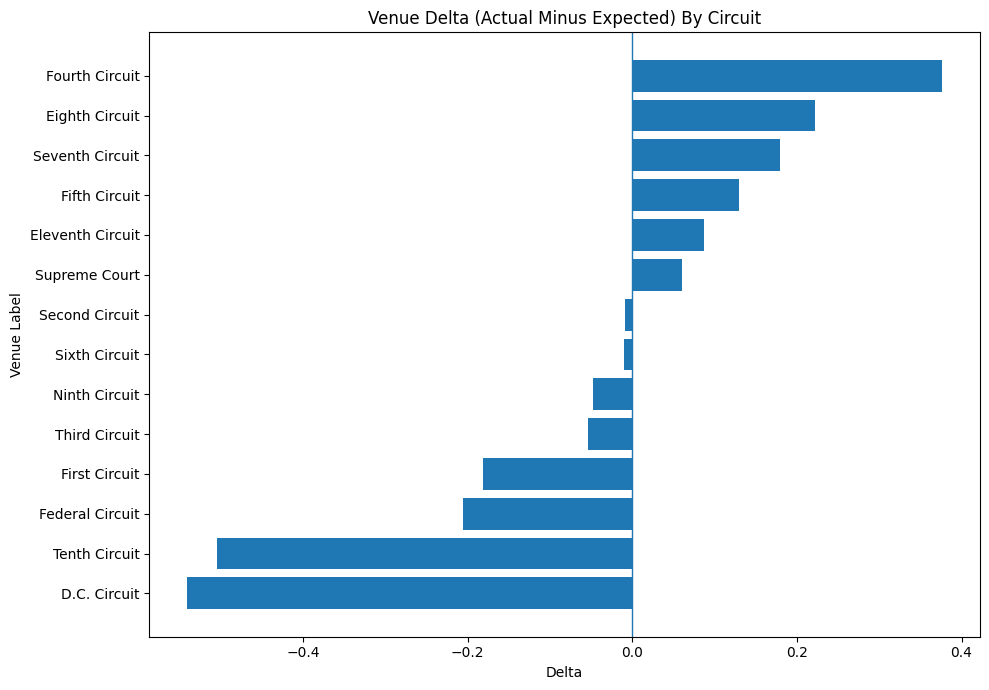

In [80]:
# Sort the results by delta to ensure the bar chart is ordered
plot_df = results.sort_values("delta")

# Initialize the figure with a specified size
plt.figure(figsize=(10, 7))

# Create a horizontal bar chart of the venue deltas
plt.barh(plot_df.index, plot_df["delta"])

# Add a vertical line at 0 to separate positive and negative deltas
plt.axvline(0, linewidth=1)

# Add chart title and axis labels
plt.title("Venue Delta (Actual Minus Expected) By Circuit")
plt.xlabel("Delta")
plt.ylabel("Venue Label")

# Adjust layout to prevent clipping and display the plot
plt.tight_layout()
plt.show()

The plot provides a clear visual ranking of adjusted venue effects after controlling for case-type mix. The Fourth Circuit has the largest positive delta, followed by the Eighth and Seventh Circuits, indicating higher-than-expected fair use findings relative to their dispute-type composition. Several circuits cluster near zero, including the Second and Sixth Circuits, suggesting outcomes close to what case mix predicts. The largest negative deltas appear for the D.C. Circuit and Tenth Circuit, but these reflect very small determinate sample sizes in the underlying table and should be interpreted as unstable until uncertainty is added in the next step.

### What "Actual" And "Expected" Mean

**Actual Rate** is the Fair Use Found rate that is directly observed in the data for a given circuit.

- Use only **determinate** cases in that circuit (outcomes that clearly indicate **Fair Use Found** or **Fair Use Not Found**).
- Compute the fraction that are **Fair Use Found**.

In words: **Actual = what the circuit’s determinate cases show.**

---

**Expected Rate** is the Fair Use Found rate predicted for a circuit based only on the **mix of case types** it receives.

- First compute a baseline Fair Use Found rate for each case type using **all determinate cases in the dataset**.
- Then compute the circuit’s **case-type mix** (the share of its cases in each case type).
- Expected is the **weighted average** of the case-type baselines using the circuit’s mix.

In words: **Expected = what the circuit would look like if outcomes depended only on dispute type, not venue.**

---

**Delta** is the adjusted venue effect:

- **Delta = Actual − Expected**

Interpretation:
- **Delta > 0**: Fair Use Found occurs **more often than expected** given the circuit’s case mix.
- **Delta < 0**: Fair Use Found occurs **less often than expected** given the circuit’s case mix.

Note: Delta reflects a case-mix adjustment, not a causal claim by itself. Small sample sizes can produce unstable deltas.